# Exercise 1: Simplified motor

In this exercise you will learn how to set up a simulation of the magnetic field of a simplified motor using the open-source Finite Element library [Nutils]. The motor consists of a single coil and an ellipsoidal, iron rotor. We assume that the magnetic field in the domain of interest does not vary in the direction of rotation, hence the simulation will be essentially 2D. Furthermore, we'll simulate only a single point in time. The following figure shows the 2D domain $X$:

![domain](exercise1.svg)

TODO: Add subdomain labels, $x_0$, $x_1$, Dirichlet boundary labels.

TODO: replace dV with dS and dS with dL

TODO: replace mu with nu

TODO: let matplotlib generate svgs (with rasterized images)

TODO: split-off constraints

TODO: replace unit mag pot to W/m

The grey area, $X_\text{rotor}$, is the rotor. The red area, $X_\text{p}$, is the section of the coil with positive current density in direction $x_2$ (normal to this screen, towards you) and the blue area, $X_\text{n}$ the section with negative current density. The coil consists of $n_\text{turns}$ turns, evenly distributed, such that the current density is constant:

$$ J_i = \delta_i2 I n_\text{turns} \begin{cases}
    \left( \int_{X_\text{p}} \mathrm dV \right) ^{-1} & \text{on } X_\text{p} \\
    -\left( \int_{X_\text{n}} \mathrm dV \right) ^{-1} & \text{on } X_\text{n} \\
    0 & \text{elsewhere}
\end{cases} $$

The magnetic permeability is the permeability of vacuum everywhere except in $X_\text{rotor}$ where the permeability is 5000 times larger:

$$ \mu = \begin{cases} 5000 \mu_0 & \text{on } X_\text{rotor} \\ \mu0 & \text{elsewhere} \end{cases} $$

The objective is to determine the torque applied to the rotor. For this we need to solve the magnetic field in the domain of interest. In 3D the magnetic field is described by

$$ \nabla_j\left(\frac{1}{\mu} \nabla_j(A_i)\right) = -J_i, $$

where $A$ is the magnetic vector potential, $\mu$ is the piecewise constant permeability and $J$ is the current density. The magnetic field density is then given by the curl of $A$, $B_i = \epsilon_{ijk} \nabla_j(A_k)$. We assume that the magnetic field does not vary in $x_2$, $\nabla_2(B_i) = 0$, hence $A_0$ and $A_1$ are zero and the governing equation simplifies to

$$ \nabla_i\left(\frac{1}{\mu} \nabla_i(A_2)\right) = -J_2. \quad\text{on } X. $$

Given the magnetic vector potential, we can determine the torque by integrating the Maxwell stress tensor over an annulus enclosing the rotor.

[Nutils]: https://nutils.org

## Import modules

We start with importing the Python modules we need in this script: [Nutils] (the Finite Element library), [NumPy] and [Matplotlib] (the scientific plotting library).

[Nutils]: https://nutils.org/
[NumPy]: https://numpy.org/
[Matplotlib]: https://matplotlib.org/

In [1]:
import csgmsh.mesh
from csgmsh.shape import Circle, Ellipse
import numpy
import nutils.export, nutils.function, nutils.mesh
from nutils.expression_v2 import Namespace
from nutils.solver import System
from matplotlib import pyplot

from nutils.SI import CurrentDensity, ElectricCurrent, Force, Length, MagneticFieldStrength, MagneticFluxDensity
MagneticPotential = MagneticFluxDensity * Length
Permeability = MagneticFluxDensity / MagneticFieldStrength
Torque = Force * Length

## Define parameters

In [2]:
domain_radius = Length('10cm')
current = nutils.function.field('I') * ElectricCurrent('A')
nturns = 100
stack_length = Length('10cm')
args = System(((current - ElectricCurrent('10A')) / 'A')**2, 'I').solve()

solve > optimizing for argument I () using direct method
solve > residual norm: 0.0e+00
solve > optimal value: 0.0e+00


## Define reference values

In [3]:
ref_length = domain_radius
ref_area = numpy.pi * domain_radius**2
ref_flux_density = MagneticFluxDensity('T')

## Generate mesh

We use [gmsh] to generate a mesh for domain $X$. The Python library [csgmsh] provides a convenient interface for defining the relevant subdomains, collected in variable `groups`. [gmsh] writes the generated mesh to a file. As [gmsh] doesn't support dimensional quantities, we generate a mesh in dimensionless quantities by dividing all lengths by `ref_length`.

[gmsh]: https://gmsh.info/
[csgmsh]: https://github.com/evalf/csgmsh

In [4]:
R = domain_radius / ref_length
R_inner_torque_probe = .35 * R
height_torque_probe = 0.1 * domain_radius
R_outer_torque_probe = R_inner_torque_probe + height_torque_probe / ref_length
shaft = Circle(radius=.1*R)
groups = dict(
    domain = Circle(radius=R) - shaft,
    p = Circle(radius=.1*R, center=[-.5*R,.3*R]),
    n = Circle(radius=.1*R, center=[ .5*R,.3*R]),
    rotor = Ellipse(width=.6*R, height=.4*R, angle=30) - shaft,
    torque_probe = Circle(radius=R_outer_torque_probe) - Circle(radius=R_inner_torque_probe),
)
csgmsh.mesh.write('exercise1.msh', groups=groups, elemsize=0.1*R, order=2)

[  0%] Fragments
[ 10%] Fragments
[ 20%] Fragments
[ 30%] Fragments
[ 40%] Fragments
[ 50%] Fragments
[ 60%] Fragments
[ 70%] Fragments - Filling splits of edges
[ 80%] Fragments
[ 90%] Fragments
Meshing 1D...
[  0%] Meshing curve 1 (Ellipse)
[ 20%] Meshing curve 2 (Ellipse)
[ 30%] Meshing curve 3 (Ellipse)
[ 50%] Meshing curve 4 (Ellipse)
[ 60%] Meshing curve 5 (Ellipse)
[ 80%] Meshing curve 6 (Ellipse)
[ 90%] Meshing curve 7 (Ellipse)
Done meshing 1D (Wall 0.00846774s, CPU 0s)
Meshing 2D...
[  0%] Meshing surface 2 (Plane, Frontal-Delaunay)
[ 20%] Meshing surface 3 (Plane, Frontal-Delaunay)
[ 30%] Meshing surface 4 (Plane, Frontal-Delaunay)
[ 50%] Meshing surface 8 (Plane, Frontal-Delaunay)
[ 60%] Meshing surface 9 (Plane, Frontal-Delaunay)
[ 80%] Meshing surface 10 (Plane, Frontal-Delaunay)
[ 90%] Meshing surface 11 (Plane, Frontal-Delaunay)
Done meshing 2D (Wall 0.0212863s, CPU 0.019827s)
Meshing order 2 (curvilinear on)...
[  0%] Meshing curve 1 order 2
[ 10%] Meshing curve 2 orde

## Initialize a namespace

A Nutils [Namespace] is a collection of variables and a parser for expressions using [Einstein notation].

[Namespace]: https://docs.nutils.org/en/stable/nutils/expression_v2/#nutils.expression_v2.Namespace
[Einstein notation]: https://en.wikipedia.org/wiki/Einstein_notation

In [5]:
ns = Namespace()

## Load mesh

We load the mesh generated in the previous step with Nutils. Nutils separates the mesh into a [topology] and a geometry, respectively variables `X` and `ns.x` in the code below. This separation allows the geometry to be variable ([example](https://examples.nutils.org/official-turek/)). The mesh was generated with dimensionless quantities w.r.t. reference `ref_length`. We multiply the geometry with `ref_length` to obtain the geometry with correct dimensions.

We also define the gradient operator `ns.grad`, the jacobians `ns.dV` and `ns.dS` and the normal `ns.n` w.r.t. geometry `ns.x` and define the polar coordinates `ns.r` and `ns.phi` and unit vectors `ns.er` and `ns.ephi`.

Finally we define `ns.lstack` as the stack length of the motor.

[topology]: https://docs.nutils.org/en/stable/nutils/topology/#nutils.topology.Topology

In [6]:
X, ns.x = nutils.mesh.gmsh('exercise1.msh')
ns.x *= ref_length

ns.define_for('x', gradient='grad', jacobians=('dV', 'dS'), normal='n')

ns.r = numpy.linalg.norm(ns.x)
ns.phi = numpy.arctan2(ns.x[1] / ref_length, ns.x[0] / ref_length)

ns.er = nutils.function.normalized('grad_i(r)' @ ns)
ns.ephi = nutils.function.normalized('grad_i(phi)' @ ns)

ns.lstack = stack_length

gmsh > loaded 2d gmsh topology consisting of #846 elements
- volume groups: domain #846, p #7, n #7, rotor #51, torque_probe #55
gmsh > 1304 vertices are not used


## Define plot function

We define functions `plot_field(fun, unit, **kwargs)` and `print_scalar(scalar, unit)`. Skip the implementation on first reading.

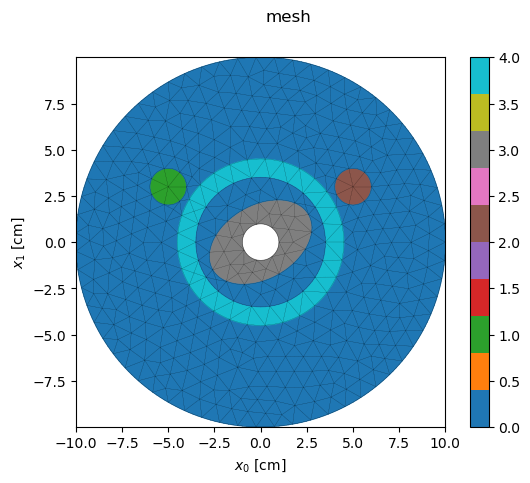

In [7]:
smpl = X.sample('bezier', 5)
bnd_smpl = X.boundary.sample('bezier', 5)

smpld_x = smpl.eval(ns.x)
bnd_smpld_x = bnd_smpl.eval(ns.x)

def plot_field(v, vunit=None, *, vlabel=None, title=None, clim=None, **kwargs):
    fig = pyplot.figure()
    ax = fig.add_subplot(1, 1, 1)
    xunit = 'cm'
    if isinstance(v, str):
        if vlabel is None:
            vlabel = v
        if title is None:
            title = v
        v = v @ ns
    v = smpl.eval(v, args or {})
    if vunit is not None:
        v /= vunit
    if isinstance(clim, str) and clim == 'symmetric':
        vmax = numpy.max(abs(v))
        clim = -vmax, vmax
    nutils.export.triplot(ax, bnd_smpld_x / xunit, hull=bnd_smpl.tri)
    im = nutils.export.triplot(
        ax,
        smpld_x / xunit,
        v,
        tri=smpl.tri,
        clim=clim,
        **kwargs)
    ax.set_xlabel(f'$x_0$ [{xunit}]')
    ax.set_ylabel(f'$x_1$ [{xunit}]')
    fig.colorbar(im, label=vlabel if vunit is None else f'{vlabel or ""} [{vunit}]')
    if title is not None:
        fig.suptitle(title)

def print_scalar(expr, unit=None):
    v = nutils.function.eval(expr @ ns, args or {})
    print((f'{expr}: {{:.3{unit}}}' if unit else f'{expr}: {{}}').format(v))

i = 1 * X.indicator('p') + 2 * X.indicator('n') + 3 * X.indicator('rotor') + 4 * X.indicator('torque_probe')
plot_field(i, hull=smpl.hull, cmap='tab10', title='mesh')

## Define knowns

We define the magnetic permeability `ns.mu` and the current density `ns.J2` according to the problem description.

`X.indicator('subdom')` is a function that evaluates to 1 inside $X_\text{subdom}$ and 0 elsewhere. `numpy.choose(index, values)` returns `values[index]` for each element of `index`.

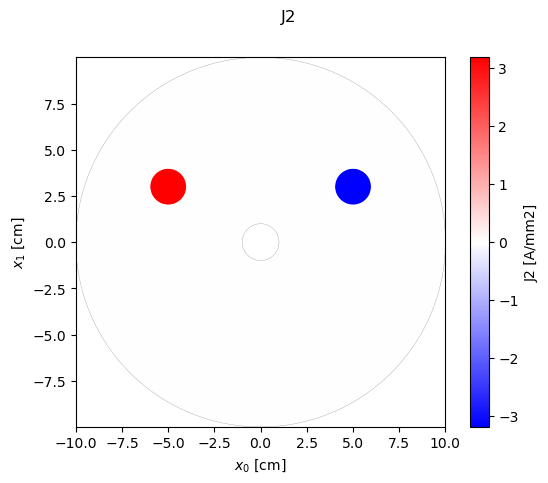

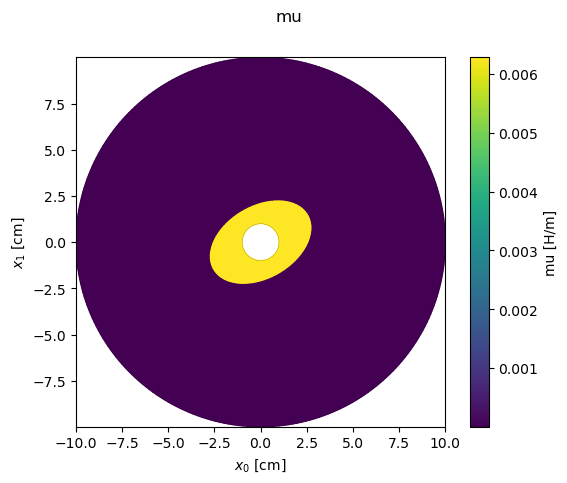

In [8]:
ns.mu0 = 4e-7 * numpy.pi * Permeability('H/m')
ns.mu = ns.mu0 * numpy.choose(X.indicator('rotor'), [1, 5000])
ns.I = current
ns.J2 = (X.indicator('p') - X.indicator('n')) * ns.I * nturns \
    / X['p'].integral('dV' @ ns, degree=1)

plot_field('J2', 'A/mm2', cmap='bwr', clim='symmetric')
plot_field('mu', 'H/m')

## Define weak formulation

The magnetic field is described by the following equation in terms of the magnetic potential $A_2$

$$ \nabla_i\left(\frac{1}{\mu} \nabla_i(A_2)\right) = -J_2 \quad\text{on } X. $$

with Dirichlet boundary condition

$$ A_2 = 0 \quad\text{at } \partial X. $$

Multiplying the differential equation with a test function $\beta_2$, integrating over $X$ and applying integration by parts to the laplace term gives the weak formulation: Find $A_2$ such that for all $\beta_2$

$$ R := \int_X \left( -\frac{1}{\mu} \nabla_i(\beta_2) \nabla_i(A_2) + \beta_2 J_2 \right)\ \mathrm dV = 0, $$

subject to $A_2 = 0$ at $\partial X$.

Finally we make the weak formulation discrete by creating a vector of basis functions $f_i$ on $X$ and restricting $A_2$ and $\beta_2$ to a linear combination of basis functions, $A_2 = \hat A_{2i} f_i$ and $\beta_2 = \hat \beta_{2i} f_i$. In the script, `X.field()` does exactly this: return the inner product of a vector of basis functions with a vector of coefficients, a [`nutils.function.Argument`] identified by the name given as first argument to `X.field()`.

We define the residual $R$ as `residual` and make the residual dimensionless by appropriate scaling of `ns.beta2` and dividing the residual by a reference area.

The Dirichlet constraints are obtained by solving the optimization problem

$$ g := \int_{\partial X} A_2^2 \ \mathrm dS = 0 $$

for the subset of $\hat A_{2}$ for which the basis functions $f$ have support on $\partial X$. The constrained coefficients are stored in `constraints`.

[`nutils.function.Argument`]: https://docs.nutils.org/en/stable/nutils/function/#nutils.function.Argument

In [9]:
ns.A2 = X.field('A2', btype='std', degree=2) * ref_flux_density * ref_length
ns.beta2 = X.field('beta2', btype='std', degree=2) * ns.mu0 * ref_length / ref_flux_density

residual = X.integral('(-grad_i(beta2) grad_i(A2) / mu + beta2 J2) dV' @ ns, degree=3) / ref_area

g = X.boundary.integral('A2^2 dS' @ ns, degree=5) / (ref_flux_density**2 * ref_length**3)
constraints = System(g, 'A2').solve_constraints(droptol=1e-15)

solve_constraints > optimizing for argument A2 (1762) with drop tolerance 1e-15
solve_constraints > residual norm: 0.0e+00
solve_constraints > optimal value: 0.0e+00
solve_constraints > constrained 140 degrees of freedom of A2


## Solve and plot

With the residual and dirichlet constraints defined, we can solve the discrete problem. The statement `System(residual, trial test).solve(constrain=constraints)` should be read as: For each `test` function find coefficients `trial` such that `residual` vanishes subject to the given Dirichlet `constraints`. Here, `test` and `trial` refer to argument names; the same as given to `X.field()` above. The result of `System.solve()` is a dictionary mapping argument names to the coefficients as `numpy.ndarray`s.

solve > solving for argument A2 (1762) using direct method
solve > residual norm: 4.0e-18


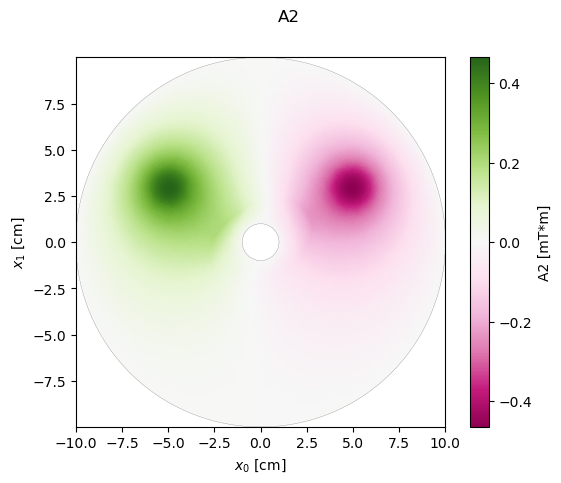

In [10]:
system = System(residual, 'A2', 'beta2')
args = system.solve(constrain=constraints, arguments=args)
plot_field('A2', 'mT*m', cmap='PiYG', clim='symmetric')

## Exercise 1.1: Plot the $x_0$ and $x_1$ components of the $B$-field

The $B$-field is the curl of the magnetic vector potential $A$. With the Levi-Civita symbol $\epsilon$ the curl can be written concisely as

$$ B_i = \epsilon_{ijk} \nabla_j(A_k). $$

Since we assume that the magnetic field does not vary in $x_2$, we can limit the $B$-field to the first two components:

$$ B_i = \epsilon_{ij2} \nabla_j(A_2) = \epsilon_{ij} \nabla_j(A_2). $$

**Exercise**: Define the $B$-field as `ns.B` and plot both components using

```python
plot_field('B_0', 'mT', cmap='PiYG', clim='symmetric')
plot_field('B_1', 'mT', cmap='PiYG', clim='symmetric')
```

The 2D Levi-Civita symbol can be obtained using `nutils.function.levicivita(2)`.

<details>
<summary>Hint</summary>

Use a namespace expression assignment:

```python
ns.eps = nutils.function.levicivita(2)
ns.B_i = '...'
```
</details>

**Bonus**: Also plot the radial and angular components of $B$.

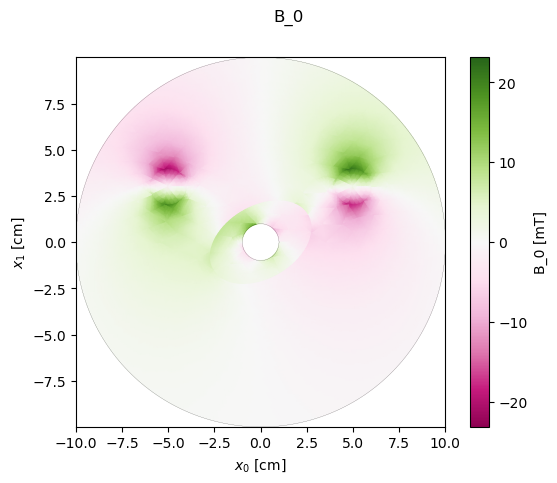

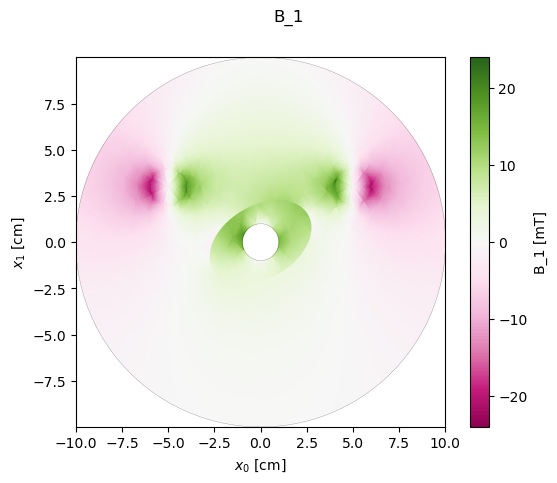

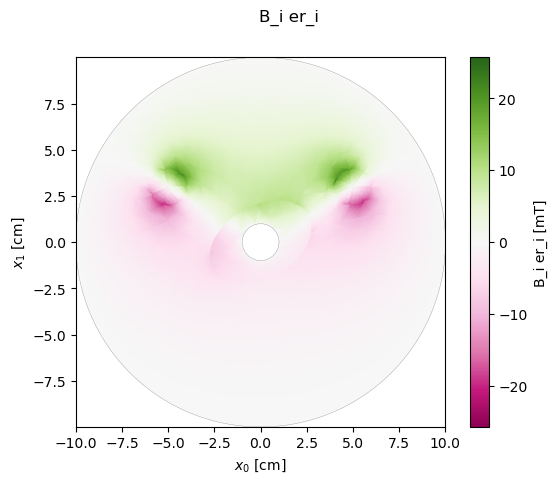

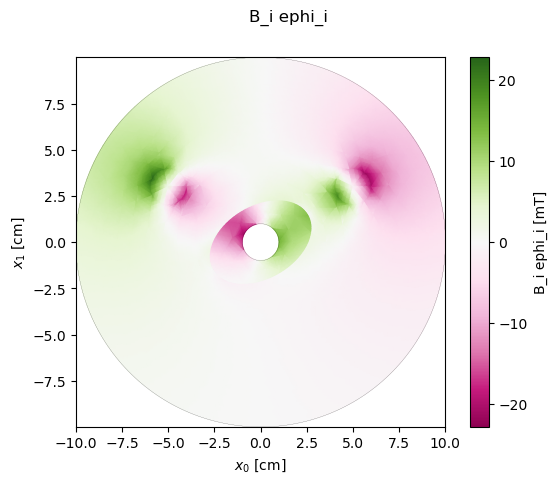

In [11]:
# Solution:
ns.eps = nutils.function.levicivita(2)
ns.B_i = 'eps_ij grad_j(A2)'
plot_field('B_0', 'mT', cmap='PiYG', clim='symmetric')
plot_field('B_1', 'mT', cmap='PiYG', clim='symmetric')
# Bonus:
plot_field('B_i er_i', 'mT', cmap='PiYG', clim='symmetric')
plot_field('B_i ephi_i', 'mT', cmap='PiYG', clim='symmetric')

## Exercise 1.2: Compute the flux in the coil

The flux $\Phi$ through a surface $S$ is defined as

$$ \Phi(S) := \int_S B_k n_{Sk} \ \mathrm dS, $$

where $n_{Si}$ is a normal of $S$. Substituting the magnetic vector potential for $B$ gives

$$ \Phi(S) = \int_S \epsilon_{ijk} \nabla_i(A_j) n_{Sk} \ \mathrm dS. $$

By [Stokes' theorem] we can write the surface integral as a contour integral:

$$ \Phi(S) = \oint_{\partial S} \epsilon_{ijk} n_{\partial Si} A_j n_{Sk} \ \mathrm dL, $$

where $n_{\partial Si}$ is the normal of the boundary of $S$.

The objective is to compute the flux through the coil, $S_\text{coil}$ with $n_{S_\text{coil}}$ pointing in the direction of $x_1$. Since we assume that the magnetic field does not vary in $x_2$ we can simplify the contour integral to

$$ \Phi(S_\text{coil}) = l_\text{stack} \left( \left. A_2 \right|_{x=c_p} - \left. A_2 \right|_{x=c_n} \right), $$

where $c_p$ is the center of the positive side of the coil, $c_n$ is the center of the negative side of the coil and $l_\text{stack}$ is the stack length. Out of convenience we approximate $\left. A_2 \right|_{x_p}$ with an average of $A_2$ over the entire positive side of the coil, $X_p$, and similarly for $\left. A_2 \right|_{x_n}$:

$$ \Phi(S_\text{coil}) \approx l_\text{stack} \left( \frac{\int_{X_p} A_2 \ \mathrm dV}{\int_{X_p} \mathrm dV} - \frac{\int_{X_n} A_2 \ \mathrm dV}{\int_{X_n} \ \mathrm dV} \right). $$

**Exercise**: Define the flux through the coil in direction $x_1$ as `ns.flux` and print the flux using

```python
print_scalar('flux', 'mWb')
```

The function `print_scalar` is alread defined above. The stack length $l_\text{stack}$ is available as `stack_length` and `ns.lstack`.

[Stokes' theorem]: https://en.wikipedia.org/wiki/Stokes%27_theorem

In [12]:
# Solution:
ns.flux = ns.lstack * (
    X['p'].integral('A2 dV' @ ns, degree=3) / X['p'].integral('dV' @ ns, degree=3)
    - X['n'].integral('A2 dV' @ ns, degree=3) / X['n'].integral('dV' @ ns, degree=3)
)
print_scalar('flux', 'mWb')

flux: 0.083mWb


## Exercise 1.3: Compute the torque applied to the rotor

The torque applied to the rotor can be computed via Arkkio's method by integrating the Maxwell stress tensor over an annulus enclosing the rotor:

$$ \tau_\text{rotor} = \frac{l_\text{stack}}{\mu_0 \Delta r} \int_{X_\text{torque probe}} B_i e_{ri} B_j e_{\phi j} r \ \mathrm dV, $$

where $e_{ri}$ is the unit vector in direction $r$ and $e_{\phi i}$ is the unit vector in direction $\phi$.

**Exercise**: Define the torque applied to the rotor as `ns.torque` by applying Arkkio's method on subdomain `X['torque_probe']` and print the torque using

```python
print_scalar('torque', 'mN*m')
```

The height of the annulus $\Delta r$ is available as `height_torque_probe` (dimension: length), the vector $e_{r}$ as `ns.er` and the vector $e_{\phi}$ as `ns.ephi`.

<details>
<summary>Hint</summary>
    
The magnetic flux density in direction $r$ is given by `'B_i er_i' @ ns`.

</details>

In [13]:
# Solution:
ns.torque = X['torque_probe'].integral('B_i er_i B_j ephi_j r dV / mu' @ ns, degree=6) \
    * stack_length / height_torque_probe
print_scalar('torque', 'mN*m')

torque: 0.633mN*m


## Exercise 1.4: Find the required current for a specific torque

In [14]:
# Solution:
from nutils_solver_extra import minimize
args = minimize(
    ((ns.torque - Torque('1mN*m')) / 'N*m')**2,
    residual,
    'I',
    'A2',
    'beta2',
    tol=1e-8,
    constrain=constraints,
    arguments=args,
)
print_scalar('I', 'A')

minimize > minimizing for I () via A2 (1762,)
minimize > iter 0 > scalar = 1.348e-07, norm([grad(scalar), residual]) = 9.294e-08
minimize > iter 1 > scalar = 6.537e-08, norm([grad(scalar), residual]) = 9.117e-08
minimize > iter 2 > scalar = 1.180e-09, norm([grad(scalar), residual]) = 1.112e-08
minimize > iter 3 > scalar = 7.003e-13, norm([grad(scalar), residual]) = 2.664e-10
I: 12.576A
